# WPP Feature

This section focuses on preprocessing and cleaning the WPP dataset. This external dataset provides provide valuable socioeconomic context for both consumers and merchants. These features allow us to identify regions with higher business density, economic activity, and purchasing power, which helps us rank merchants by their growth potential in strong markets. They also help detect fraud patterns by flagging transactions that occur in areas with unusually low economic activity or atypical business structures relative to the transaction size or merchant type.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import geopandas as gpd
from matplotlib.colors import ListedColormap
from pathlib import Path
import seaborn as sns

## Loading Dataset

In [ ]:
RAW_EXT = Path("../data/raw/external_dataset")
CUR = Path("../data/curated")

In [44]:
# Load data files

# Occupation
df_13 = pd.read_csv(RAW_EXT / "2021_WPP_SA2_for_AUS_short-header/2021 Census WPP Statistical Area 2 for AUS/2021Census_W13_AUST_POW_SA2.csv")

# Occupation by owner managers by num of employees
df_14 = pd.read_csv(RAW_EXT / "2021_WPP_SA2_for_AUS_short-header/2021 Census WPP Statistical Area 2 for AUS/2021Census_W14_AUST_POW_SA2.csv")
shp_file = RAW_EXT / "sa2shape/SA2_2021_AUST_GDA2020.shp"

# Load metadata file
meta = pd.read_excel(RAW_EXT / "2021_WPP_SA2_for_AUS_short-header/Metadata_2021_WPP_DataPack_R1_R2.xlsx",
                     sheet_name="Descriptor Information", skiprows=10)

col_map = dict(zip(meta["Short"], meta["Long"]))
df_13 = df_13.rename(columns=lambda x: col_map.get(x, x))
df_14 = df_14.rename(columns=lambda x: col_map.get(x, x))

## Checking Null

In [45]:
pd.set_option("display.max_rows", None)   # Show all rows
pd.set_option("display.max_columns", None) # Show all columns 

df_13.isna().sum()


POW_SA2_CODE_2021                                                                                 0
Managers_Managers_nfd_Males                                                                       0
Managers_Managers_nfd_Females                                                                     0
Managers_Managers_nfd_Persons                                                                     0
Managers_Chief_Executives_General_Managers_and_Legislators_Males                                  0
Managers_Chief_Executives_General_Managers_and_Legislators_Females                                0
Managers_Chief_Executives_General_Managers_and_Legislators_Persons                                0
Managers_Farmers_and_Farm_Managers_Males                                                          0
Managers_Farmers_and_Farm_Managers_Females                                                        0
Managers_Farmers_and_Farm_Managers_Persons                                                        0


In [46]:
df_14.isna().sum()


POW_SA2_CODE_2021                                                                                                            0
Incorporated_Enterprises_Managers_Owner_Managers_of_enterprises_with_Nil_employees                                           0
Incorporated_Enterprises_Managers_Owner_Managers_of_enterprises_with_1_19_employees                                          0
Incorporated_Enterprises_Managers_Owner_Managers_of_enterprises_with_20_or_more_employees                                    0
Incorporated_Enterprises_Managers_Owner_Managers_of_enterprises_with_Not_Stated                                              0
Incorporated_Enterprises_Managers_Total                                                                                      0
Incorporated_Enterprises_Professionals_Owner_Managers_of_enterprises_with_Nil_employees                                      0
Incorporated_Enterprises_Professionals_Owner_Managers_of_enterprises_with_1_19_employees                       

## Data Shape



In [47]:
print("df_13:", df_13.shape) 
print("df_14:", df_14.shape)


df_13: (2472, 187)
df_14: (2472, 151)


# Feature Engineering for merchant fraud:
- Proportion of unincorporated enterprises: higher proportion indicates higher merchant fraud risk
- Proportion of conmpanies that does not have / not state num of employees


### Proportion of unincorporated enterprises
- incorporated -> (Pty, Ltd), more stable and low fraud risk
- unincorporated -> higher fraud risk


fraud_risk
low     2454
high      18
Name: count, dtype: int64
      POW_SA2_CODE_2021  prop_unincorporated fraud_risk
284           114011275             1.000000       high
526           124021456             1.000000       high
1267          304041099             1.000000       high
1662          318021477             0.876923       high
1697          319021510             1.000000       high
1796          403041079             0.807018       high
1856          406021138             1.000000       high
1857          406021139             0.804348       high
2004          505031106             1.000000       high
2057          507011151             1.000000       high
2145          511031281             1.000000       high
2172          601031014             0.809524       high
2234          604011075             0.823529       high
2259          699999499             0.808086       high
2359          801011144             1.000000       high
2396          801051123             1.000

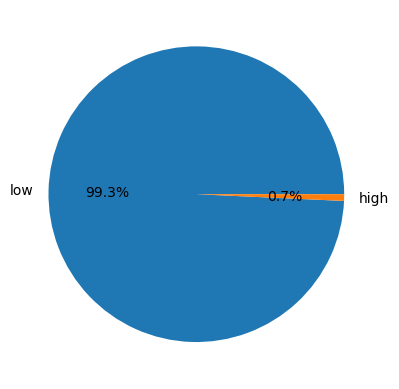

In [48]:
# proportion of incorporated vs unincorporated
inc_cols = [col for col in df_14.columns if "Incorporated" in col]
uninc_cols = [col for col in df_14.columns if "Unincorporated" in col]

# check feature for NaN value and replace with 0
df_14[inc_cols] = df_14[inc_cols].fillna(0)
df_14[uninc_cols] = df_14[uninc_cols].fillna(0)

df_inc = df_14[["POW_SA2_CODE_2021"] + inc_cols]   # 50 rows
df_uninc = df_14[["POW_SA2_CODE_2021"] + uninc_cols] # 50 rows

# extract totals
total_inc = df_inc["Incorporated_Enterprises_Total_Total"]
total_uninc = df_uninc["Unincorporated_Enterprises_Total_Total"]

# proportion of inc per SA2: higher prop indicates higher merchant fraud risk
prop_uninc = total_uninc / (total_inc + total_uninc)
prop_unincc = pd.DataFrame({
    "POW_SA2_CODE_2021": df_14["POW_SA2_CODE_2021"],
    "prop_unincorporated": prop_uninc
})

# check and replace NaN values with 0 (because of 0 / int = NaN)
prop_unincc["prop_unincorporated"] = prop_unincc["prop_unincorporated"].fillna(0)


# plot with threshold 0.8
prop_unincc["fraud_risk"] = np.where(
    prop_unincc["prop_unincorporated"] >= 0.8, "high", "low"
)
print(prop_unincc["fraud_risk"].value_counts())
print(prop_unincc[prop_unincc["fraud_risk"] == "high"]) 

# plot pie chart
counts = prop_unincc["fraud_risk"].value_counts()
plt.pie(counts, labels=counts.index, autopct="%1.1f%%")
plt.show()

### Outlier Analysis: Proportion of Unincorporated Enterprises

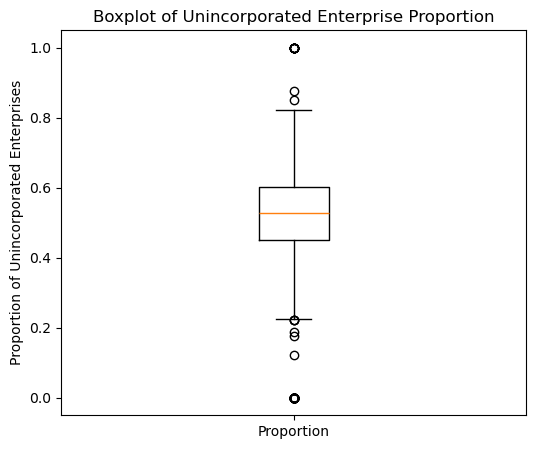

In [49]:
# Boxplot for the proportion of unincorporated enterprises
plt.figure(figsize=(6, 5))
plt.boxplot(prop_unincc["prop_unincorporated"], vert=True, labels=["Proportion"])

plt.title("Boxplot of Unincorporated Enterprise Proportion")
plt.ylabel("Proportion of Unincorporated Enterprises")
plt.show()


The boxplot does not show per-SA2 distributions. It shows the distribution of SA2-level proportions across Australia. Most SA2 regions have 40–60% unincorporated enterprises, but there are some extreme cases with nearly all incorporated or nearly all unincorporated.

### Proportion of companies with no employees/ not stated
- companies that does not have employees (both not stated and "zero")

fraud_risk
low                      1758
high                      586
no_data_or_low_volume     128
Name: count, dtype: int64
      POW_SA2_CODE_2021  num_owner_managers  share_nil  share_not_stated  \
0             101021007                 404   0.668317          0.000000   
14            101041020                 651   0.674347          0.007680   
33            102011033                 190   0.663158          0.000000   
37            102011037                 272   0.702206          0.000000   
38            102011038                 340   0.641176          0.014706   
45            102021045                 240   0.650000          0.012500   
82            104011081                 762   0.633858          0.023622   
84            104021083                 558   0.675627          0.007168   
87            104021086                 240   0.658333          0.000000   
88            104021087                 298   0.671141          0.020134   
134           107011132              

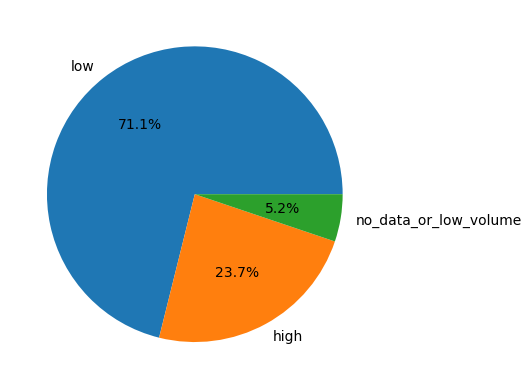

In [50]:
# enterprise size
nil = df_14["Total_Total_Owner_Managers_of_enterprises_with_Nil_employees"]
small = df_14["Total_Total_Owner_Managers_of_enterprises_with_1_19_employees"]
large = df_14["Total_Total_Owner_Managers_of_enterprises_with_20_or_more_employees"]
not_stated = df_14["Total_Total_Owner_Managers_of_enterprises_with_Not_Stated"]

total = nil + small + large + not_stated

# Proportion of each enterprise size with zero division error handling
share_nil = nil.div(total).where(total > 0)
share_ns  = not_stated.div(total).where(total > 0)
share_nil_or_ns = share_nil.add(share_ns, fill_value=0).where(total > 0)

# Laplace smoothing 
alpha, beta = 1.0, 1.0
x = nil + not_stated
n = total
smoothed = (x + alpha) / (n + alpha + beta)

suspicious = pd.DataFrame({
    "POW_SA2_CODE_2021": df_14["POW_SA2_CODE_2021"],
    "num_owner_managers": total,
    "share_nil": share_nil,
    "share_not_stated": share_ns,
    "share_nil_or_notstated": smoothed # with smoothing
})

# Volume filter (avoid tiny, noisy cells)
MIN_N = 50
valid = (suspicious["num_owner_managers"] >= MIN_N) & suspicious["share_nil_or_notstated"].notna()

# Data-driven threshold among valid rows
threshold = suspicious.loc[valid, "share_nil_or_notstated"].quantile(0.75)

# After smoothing & with explicit no-data/low-volume
suspicious["fraud_risk"] = np.select(
    [
        suspicious["num_owner_managers"].lt(MIN_N) | suspicious["share_nil_or_notstated"].isna(),
        suspicious["share_nil_or_notstated"].ge(threshold)
    ],
    ["no_data_or_low_volume", "high"],
    default="low"
)

assert suspicious["share_nil_or_notstated"].dropna().between(0,1).all()

print(suspicious["fraud_risk"].value_counts())
print(suspicious[suspicious["fraud_risk"] == "high"])

# Plot pie chart
counts = suspicious["fraud_risk"].value_counts()
plt.pie(counts, labels=counts.index, autopct="%1.1f%%")
plt.show()


### Outlier Analysis

In [51]:
q1 = suspicious["share_nil_or_notstated"].quantile(0.25) 
q3 = suspicious["share_nil_or_notstated"].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr 
upper_bound = q3 + 1.5 * iqr 
outliers = suspicious[(suspicious["share_nil_or_notstated"] < lower_bound) | (suspicious["share_nil_or_notstated"] > upper_bound)] 
print("Number of outliers:", outliers.shape[0]) 
print("Outliers: \n", outliers)

Number of outliers: 21
Outliers: 
       POW_SA2_CODE_2021  num_owner_managers  share_nil  share_not_stated  \
373           118011342                   5   0.000000          0.000000   
615           127021521                1610   0.288820          0.001863   
1476          310041301                  15   0.000000          0.000000   
1527          312021347                  74   0.256757          0.000000   
1758          402041042                  38   0.263158          0.000000   
1902          501021011                 375   0.269333          0.010667   
1959          504031064                   4   0.000000          0.000000   
2004          505031106                   7   1.000000          0.000000   
2075          507031172                  88   0.284091          0.000000   
2148          511031284                   7   1.000000          0.000000   
2274          701021015                   4   0.000000          0.000000   
2276          701021017                  98   0.24489

Text(0.5, 1.0, 'All SA2s by Fraud Risk')

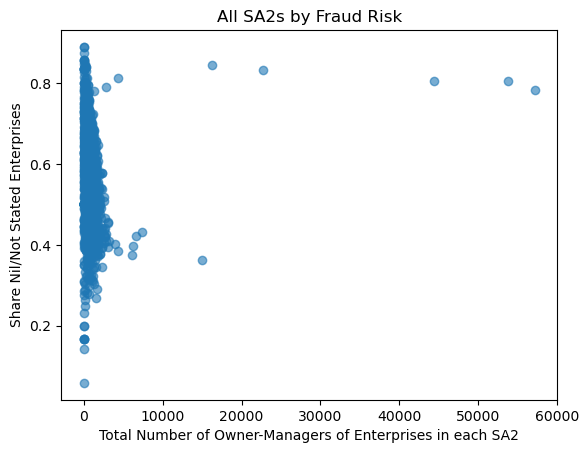

In [52]:
plt.scatter(
    suspicious["num_owner_managers"],
    suspicious["share_nil_or_notstated"],
    alpha=0.6
)

plt.xlabel("Total Number of Owner-Managers of Enterprises in each SA2")
plt.ylabel("Share Nil/Not Stated Enterprises")
plt.title("All SA2s by Fraud Risk")

In [53]:
suspicious["num_owner_managers"].mean()

670.6080097087379

The scatter plot of total owner-managers per SA2 (x-axis) against the proportion of enterprises with nil or not-stated employees (y-axis) highlights a clear pattern: regions with small numbers of owner-managers show extreme variability in proportions, ranging from 0 to nearly 1.0, while larger regions with thousands of owner-managers cluster more tightly around mid-range values. This demonstrates that outliers at the top and bottom of the proportion scale are largely driven by unstable ratios in low-volume areas, rather than genuine anomalies. Given that the average SA2 has around 670 owner-managers, applying a minimum-volume filter of 50 owner-managers is a conservative but essential safeguard to avoid misclassifying noise as fraud risk. In effect, enterprise size distributions become more reliable indicators of risk only when based on sufficiently large underlying populations

# Feature engineering for customer fraud:
- low skill occupation

### Proportion of occupation groups:
- proportion of low_skills are use as they have higher fraud prob (logically)

294
      POW_SA2_CODE_2021  prob_fraud
2183          601041025    1.000000
526           124021456    0.750000
1816          404021098    0.732143
1959          504031064    0.695652
1367          308031211    0.683217
1485          311021308    0.649549
2381          801041119    0.633028
1068          213041461    0.632911
1321          306021153    0.632150
1951          504031055    0.625000


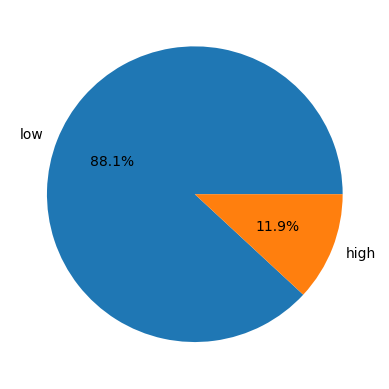

In [54]:
# High skill = managers + professionals
managers = df_13["Managers_Total_Persons"]
professionals = df_13["Professionals_Total_Persons"]
high_skill = managers + professionals

# Medium skill = technicians & trades, clerical & admin
technicians = df_13["Technicians_and_Trades_Workers_Total_Persons"]
clerical = df_13["Clerical_and_Administrative_Workers_Total_Persons"]
medium_skill = technicians + clerical

# Low skill = Community & Personal Service, Sales, Machinery Operators & Drivers, Labourers
service = df_13["Community_and_Personal_Service_Workers_Total_Persons"]
sales = df_13["Sales_Workers_Total_Persons"]
machinery = df_13["Machinery_Operators_and_Drivers_Total_Persons"]
labourers = df_13["Labourers_Total_Persons"]
low_skill = service + sales + machinery + labourers

total = low_skill + medium_skill + high_skill
prob_fraud = (low_skill / total).where(total > 0) # avoid NaN


# Combine into a DataFrame
fraud_risk_area = pd.DataFrame({
    "POW_SA2_CODE_2021": df_13["POW_SA2_CODE_2021"],
    "prob_fraud": prob_fraud  # same as your definition
})

threshold = 0.5
fraud_risk_area["fraud_risk"] = np.where(
    fraud_risk_area["prob_fraud"] >= threshold, "high", "low"
)

print(len(fraud_risk_area.loc[fraud_risk_area["fraud_risk"] == "high"])) # 294 locations

# Top-10 areas with high consumer fraud prob as number of low_skill workers are high
print(fraud_risk_area.loc[fraud_risk_area["prob_fraud"] >= threshold,
                          ["POW_SA2_CODE_2021","prob_fraud"]]
      .sort_values("prob_fraud", ascending=False).head(10))

# Plot pie chart
counts = fraud_risk_area["fraud_risk"].value_counts()
plt.pie(counts, labels=counts.index, autopct="%1.1f%%")
plt.show()

### Distribution

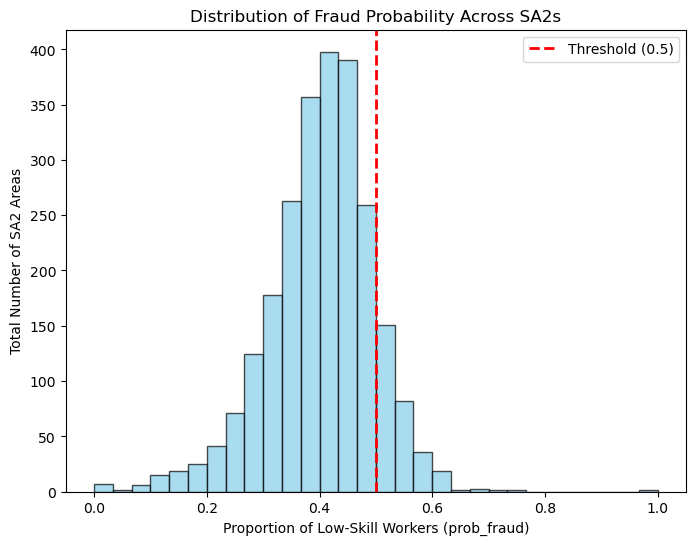

In [55]:
plt.figure(figsize=(8,6))
plt.hist(fraud_risk_area["prob_fraud"].dropna(), bins=30, color="skyblue", edgecolor="black", alpha=0.7)

# Add threshold line
plt.axvline(0.5, color="red", linestyle="--", linewidth=2, label="Threshold (0.5)")

plt.xlabel("Proportion of Low-Skill Workers (prob_fraud)")
plt.ylabel("Total Number of SA2 Areas")
plt.title("Distribution of Fraud Probability Across SA2s")
plt.legend()
plt.show()


### Visualisation based on the majority occupation in each SA2

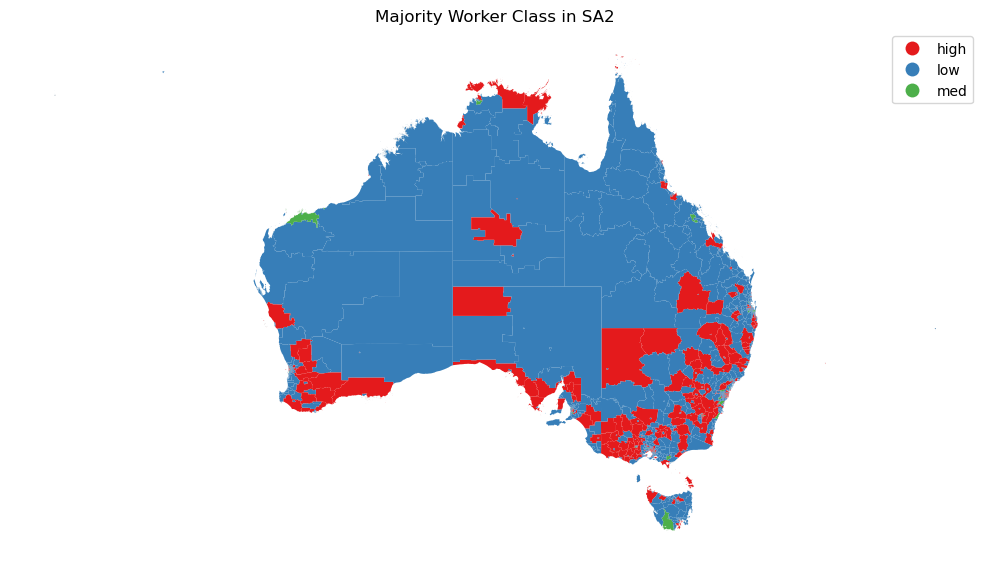

In [56]:
# probability occupation group for mapping areas 
total = (high_skill + medium_skill + low_skill)
prop_low  = (low_skill    / total).where(total > 0).fillna(0)
prop_med  = (medium_skill / total).where(total > 0).fillna(0)
prop_high = (high_skill   / total).where(total > 0).fillna(0)

# dataframe for merge
skill_df = pd.DataFrame({
    "POW_SA2_CODE_2021": df_14["POW_SA2_CODE_2021"].astype(str).str.zfill(9),
    "prop_low":  prop_low,
    "prop_med":  prop_med,
    "prop_high": prop_high
})

# Majority Worker Class in SA2
skill_df["majority_worker"] = skill_df[["prop_low","prop_med","prop_high"]].idxmax(axis=1).str.replace("prop_","")


# mapping
zones = gpd.read_file(shp_file)
sa2_col = "SA2_CODE21"
zones[sa2_col] = zones[sa2_col].astype(str).str.zfill(9)
gdf = zones.merge(skill_df, left_on=sa2_col, right_on="POW_SA2_CODE_2021", how="left")
cmap = ListedColormap(["#e41a1c", "#377eb8", "#4daf4a"])  # high, low, med 

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(
    column="majority_worker",
    ax=ax,
    categorical=True,
    legend=True,
    cmap=cmap,
    missing_kwds={"color": "#f0f0f0", "hatch": "///", "label": "No data"}
)

ax.set_title("Majority Worker Class in SA2")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Aggregating Features
    - SA2_code
    - inc_cols
    - uninc_cols
    - zero_employees
    - small_employees + large_employees
    - not_stated_employees
    - low_skill_occupation
    - medium_skill_occupation
    - high_skill_occupation

In [57]:
merge_features = pd.concat([
   df_14["POW_SA2_CODE_2021"].rename("SA2_code"),
   df_14["Incorporated_Enterprises_Total_Total"].rename("Incorporated"),
   df_14["Unincorporated_Enterprises_Total_Total"].rename("Unincorporated"),
   df_14["Total_Total_Owner_Managers_of_enterprises_with_Nil_employees"].rename("Enterprises with no Employees"),
   df_14["Total_Total_Owner_Managers_of_enterprises_with_Not_Stated"].rename("Enterprises with not stated Employees"),
   high_skill.rename("high_skill_occ"),
   medium_skill.rename("med_skill_occ"),
   low_skill.rename("low_skill_occ")
],
axis = 1
)

merge_features.to_csv(CUR / "WPP_cleaned.csv")

## Heatmap of feature correlation

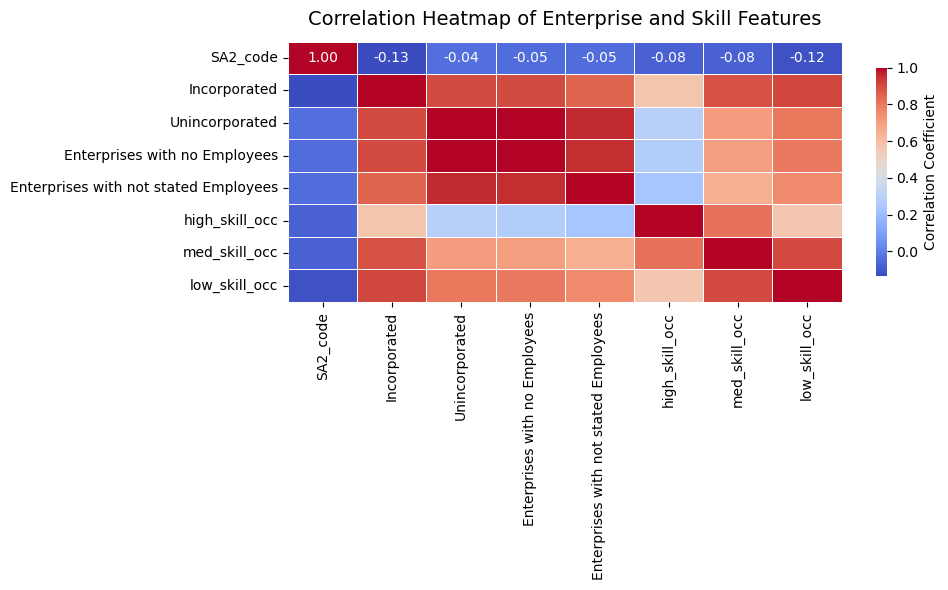

In [58]:
# assuming merge_features is already defined as in your code
# remove non-numeric column if necessary (e.g. SA2_code)
numeric_features = merge_features.select_dtypes(include=['number'])

# compute correlation matrix
corr_matrix = numeric_features.corr()

# plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,             # display correlation coefficients
    fmt=".2f",              # format to 2 decimal places
    cmap="coolwarm",        # color palette
    linewidths=0.5,         # lines between cells
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)

plt.title("Correlation Heatmap of Enterprise and Skill Features", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# Save to csv

In [59]:
merge_features.to_csv(CUR / "WPP_cleaned.csv")